Currently I'm thinking that while we're studying the various types of sources we would save a version of this notebook which focuses on each fault. 

In [79]:
%matplotlib inline
import os
import json
import codecs
import pickle
import numpy as np

import matplotlib.pyplot as plt
import openquake.hazardlib.geo.geodetic as geo
import hmtk.sources as src
import hmtk.seismicity.declusterer as decluster
import hmtk.plotting.seismicity.catalogue_plots as cp
import hmtk.plotting.seismicity as sp

from copy import deepcopy
from hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
from hmtk.plotting.seismicity.completeness import plot_stepp_1972
import hmtk.seismicity.occurrence as occurrence

from string import Template
from collections import OrderedDict
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser
from hmtk.seismicity.selector import CatalogueSelector

In [41]:
# Marmaris, Turkey
target_lon = 28.25
target_lat = 36.85

sources_file = "../geology/MarmarisDangerousSources12_300km.xml"

catalogue_filename = '../seismicity/Marmaris-catalogue1_exclude_homogenised_cleaned.csv'

In [42]:
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file() 

print 'Minimum magnitude: ', np.min(catalogue.data['magnitude'])
print 'Maximum magnitude: ', np.max(catalogue.data['magnitude'])
print 'Number of events: ', len(catalogue.data['magnitude'])
print 'Catalogue keys: '
print catalogue.data.keys()

Catalogue Attribute Identifier is not a recognised catalogue key
Minimum magnitude:  1.98
Maximum magnitude:  7.5
Number of events:  30543
Catalogue keys: 
['eventID', 'comment', 'sigmaMagnitude', 'hour', 'SemiMinor90', 'magnitude', 'Agency', 'second', 'longitude', 'month', 'depthError', 'flag', 'depth', 'magnitudeType', 'SemiMajor90', 'timeError', 'year', 'latitude', 'ErrorStrike', 'day', 'minute']


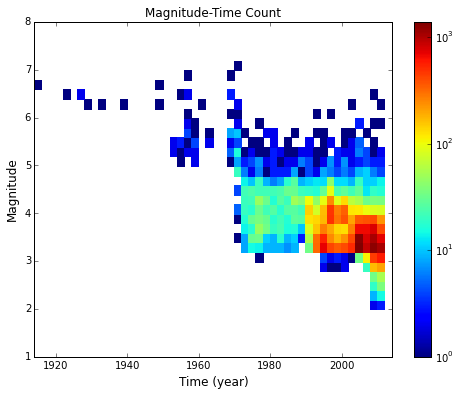

In [43]:
cp.plot_magnitude_time_density(catalogue, 0.2, 2)

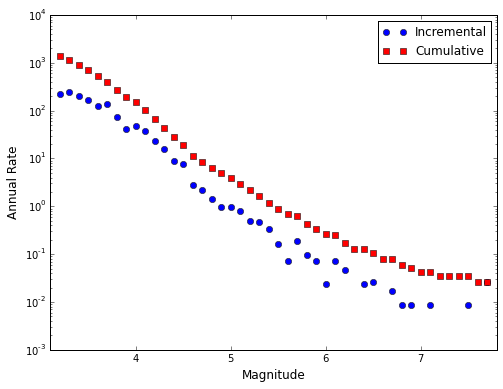

Completeness table guess
[[ 2004.      3.2]
 [ 1994.      4. ]
 [ 1974.      4.6]
 [ 1900.      6.5]]


In [44]:
completeness_table_guess = np.array([[2004, 3.2],
                                     [1994, 4.0], 
                                     [1974, 4.6], 
                                     [1900, 6.5]]) 
cp.plot_observed_recurrence(catalogue, completeness_table_guess, 0.1)
print 'Completeness table guess'
print completeness_table_guess

In [45]:
# identify clusters
declusterer = decluster.dec_gardner_knopoff.GardnerKnopoffType1()
decluster_config = {
    'time_distance_window': decluster.distance_time_windows.UhrhammerWindow(), 
    'fs_time_prop': 1.0}
cluster_index, cluster_flag = declusterer.decluster(catalogue, decluster_config)

# purge catalogue
declustered = deepcopy(catalogue)
mainshock_flag = cluster_flag == 0 
declustered.purge_catalogue(mainshock_flag)

In [68]:
# Map configuration
span = 2 # deg
map_config = {"min_lon": target_lon - 2*span, 
              "max_lon": target_lon + 2*span, 
              "min_lat": target_lat - span, 
              "max_lat": target_lat + span, "resolution": "l"}

In [69]:
# Reading the models 
parser = nrmlSourceModelParser(sources_file)

# Parse the seismic sources and save them in "source_model"
source_model = parser.read_file("Sources Around Marmaris")

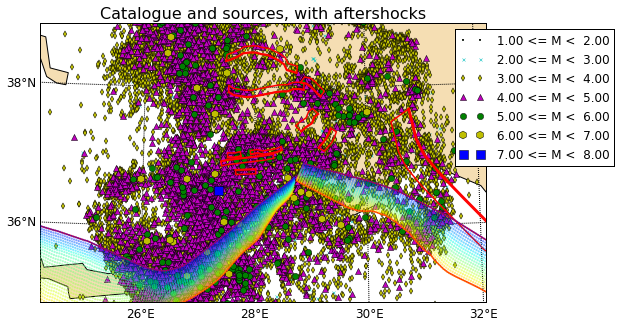

Number of events:  30543


In [70]:
my_map = HMTKBaseMap(map_config, 'Catalogue and sources, with aftershocks')
my_map.add_catalogue(catalogue, overlay=True)
my_map.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k', zorder=6)
print 'Number of events: ', len(catalogue.data['magnitude'])

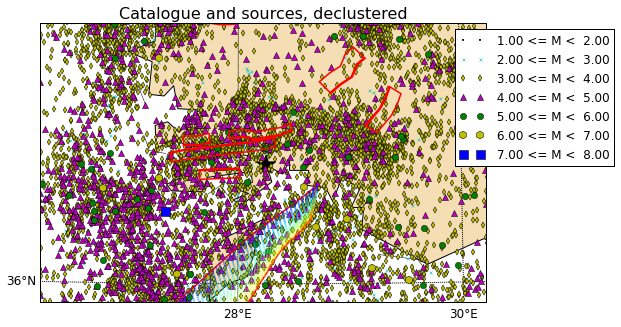

Number of events:  19048


In [18]:
my_map = HMTKBaseMap(map_config, 'Catalogue and sources, declustered')
my_map.add_catalogue(declustered, overlay=True)
my_map.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k', zorder=6)
print 'Number of events: ', len(declustered.data['magnitude'])

In [19]:
selector = CatalogueSelector(declustered, create_copy=True)

In [20]:
for source in source_model.sources:
    if isinstance(source, src.area_source.mtkAreaSource): 
        source.select_catalogue(selector)
        print 'Area source %s, name %s, # of events %8.0f' % (
            source.id, source.name, source.catalogue.get_number_events())
        #subcatalogue_area = selector.    

In [21]:
r_km = 10*np.ones_like(source_model.sources)
r_km[-1] = 30
for i, source in enumerate(source_model.sources):
    if isinstance(source, src.simple_fault_source.mtkSimpleFaultSource): 
        source.select_catalogue(selector, r_km[i])
    elif isinstance(source, src.complex_fault_source.mtkComplexFaultSource): 
        source.select_catalogue(selector, r_km[i]) 
        
    print '%s: %s, %d events wihin %g km' % (
        source.id, source.name, source.catalogue.get_number_events(), r_km[i])

TRCS394: Datca Horst North Boundary 1, 148 events wihin 10 km
TRCS391: Gokova Oren Fault Zone 1, 344 events wihin 10 km
TRCS331: Buyuk Menderes Graben North Boundary 2, 316 events wihin 10 km
TRCS271: Golgelidag Horst West Boundary - Tavas, 55 events wihin 10 km
TRCS322: Gediz Graben South Boundary, 166 events wihin 10 km
TRCS393: Gokova Oren Fault Zone 3, 191 events wihin 10 km
TRCS390: Aksu Thrust, 425 events wihin 10 km
TRCS268: Golgelidag Horst East Boundary - Akalan, 147 events wihin 10 km
TRCS913: Ula-Oren, 562 events wihin 10 km
TRCS330: Buyuk Menderes Graben North Boundary 1, 429 events wihin 10 km
HELL001: Hellenic Arc, 4236 events wihin 30 km


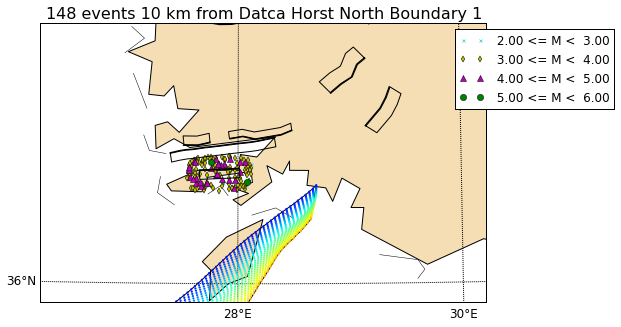

In [22]:
fault_id = 'TRCS394'
r_km = 10
source = [source for source in source_model.sources if source.id == fault_id][0]
#for i, source in enumerate(source_model.sources):
n_events = source.catalogue.get_number_events()
# if n_events < 5: continue
basemap = HMTKBaseMap(
    map_config, '%d events %d km from %s' % (n_events, r_km, source.name))
basemap.add_catalogue(source.catalogue, overlay=True)
basemap.add_source_model(source_model, area_border='k-')

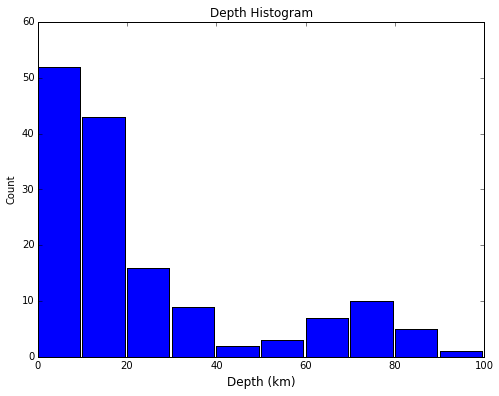

In [23]:
cp.plot_depth_histogram(source.catalogue, 10)

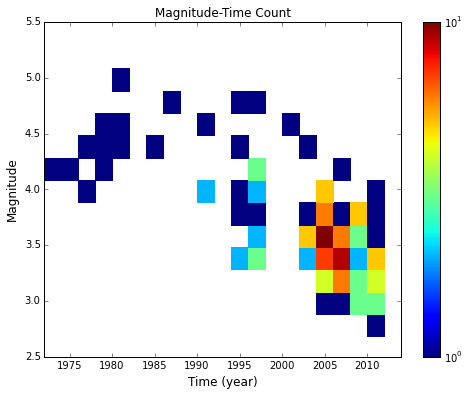

[[ 2004.      3.2]
 [ 1994.      4. ]
 [ 1974.      4.6]
 [ 1900.      6.5]]


In [24]:
cp.plot_magnitude_time_density(source.catalogue, 0.2, 2)
print completeness_table_guess

Completeness table using Stepp method (1971)
[[  2.00700000e+03   2.00000000e+00]
 [  1.99700000e+03   3.00000000e+00]
 [  1.96500000e+03   4.00000000e+00]]


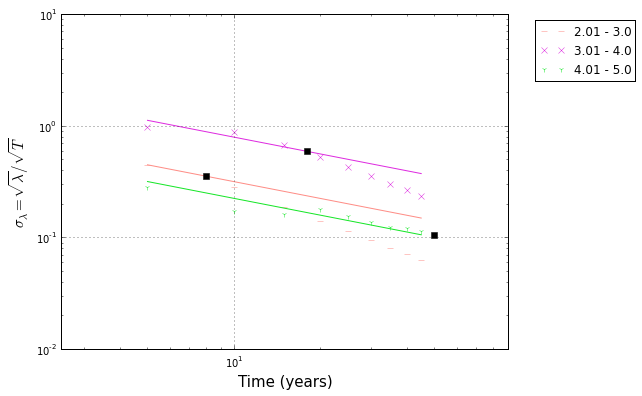

In [195]:
# Set up the configuration parameterss
complete_config = {'magnitude_bin': 1.0, 'time_bin': 5.0, 
               'increment_lock': False}

# Calling the method
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(
    source.catalogue, complete_config)

completeness_table = completeness_table[~np.isnan(completeness_table).any(axis=1)]

# Print the completeness table
print 'Completeness table using Stepp method (1971)'
print np.round(completeness_table)

# Setting configuration for the completeness plot
plot_stepp_1972.create_stepp_plot(completeness_algorithm)


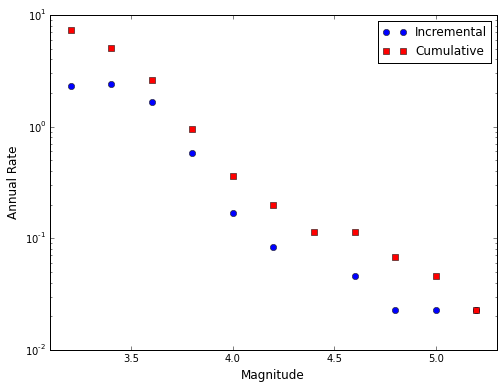

In [199]:
cp.plot_observed_recurrence(source.catalogue, completeness_table_guess, 0.2)

In [38]:
fault_file_name = '../geology/Eastern_Mediterranean_Fault_Traces.pkl'
with open(fault_file_name, 'rb') as pickle_stream:
    DATA = pickle.load(pickle_stream)

In [39]:
DATA[fault_id]['statistics']['s_mid']

5.40835

In [52]:
DATA['TRCS913']['statistics']['s_mid']

1.75

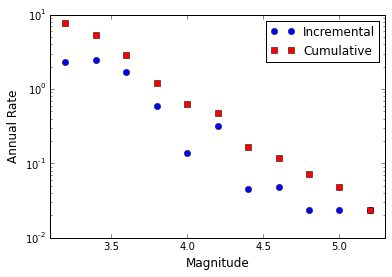

In [67]:
end_year = np.max(source.catalogue.data['year'])
recurrence = cp.get_completeness_adjusted_table(
    source.catalogue, completeness_table_guess, 0.2, end_year)
plt.semilogy(recurrence[:, 0], recurrence[:, 1], 'bo')
plt.semilogy(recurrence[:, 0], recurrence[:, 2], 'rs')
plt.xlim([recurrence[0, 0] - 0.1, recurrence[-1, 0] + 0.1])
plt.xlabel('Magnitude', fontsize='large')
plt.ylabel('Annual Rate', fontsize='large')
plt.legend(['Incremental', 'Cumulative'])
plt.show()

In [80]:
# Weichert Method
recurrence1 = occurrence.weichert.Weichert()
weichert_config = {'magnitude_interval': 0.1, 'bvalue': 1., 
                   'itstab': 1e-5, 'maxiter': 1000}
bval1, sigmab1, aval1, sigma1 = recurrence1.calculate(
    source.catalogue, weichert_config, 
    completeness=completeness_table_guess)

print "--- Weichert ---"
print "a-value = %.4f +/- %.4f, b-value = %.4f +/- %.4f" % (
    aval1, sigma1, bval1, sigmab1)

# Weighted Maximum Likelihood Method
recurrence2 = occurrence.b_maximum_likelihood.BMaxLikelihood()
wml_config = {'magnitude_interval': 0.1, 'Average Type': 'Weighted'}
bval2, sigmab2, aval2, sigma2 = recurrence2.calculate(
    source.catalogue, wml_config, 
    completeness=completeness_table_guess)

print "--- Weighted Maximum Likelihood ---"
print "a-value = %.4f +/- %.4f, b-value = %.4f +/- %.4f" % (
    aval2, sigma2, bval2, sigmab2)

--- Weichert ---
a-value = 4.1969 +/- 0.0364, b-value = 1.0316 +/- 0.0742
--- ctime 2004.0  m_c 3.2
--- ctime 1994.0  m_c 4.0
--- ctime 1974.0  m_c 4.6
--- ctime 1900.0  m_c 6.5


ValueError: zero-size array to reduction operation maximum which has no identity